<a href="https://colab.research.google.com/github/Alejandrooct/AI-course/blob/main/AI_course_Day8(dogs_cats).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##AI course

Day #8 - Wednesday December 20, 2023

Assignement: Image Classification  - Cats & Dogs in keras and pytorch

Name: Alejandro Thamm

(in image classification, the images are just classfied: the label only states: "there is a cat (dog) in this image", no bounding box coordinates)



Cat dog dataset- vgg network

Download vgg from keras for example

To with pytorch and do with keras- 2 parts

Freeze all layers except for last convolution and on

In pytorch- save the weights we trained on.

Use those weights with keras should match them.

Show confusion matrix.I



In [ ]:
# requirements

# Using the Cats and Dogs Dataset (the reduced, filtered dataset)
# build a VGG network
# Download the VGG-16 pre-trained NN model (for example)
# Do this with keras
# do this also with pytorch (so there will be 2 parts)
# Train both models with the same data.
# We should get similar results in both cases
# Compare results
#   plot the training / validation caauracy and los functions
#   plot the Confussion matrix.


##Step 1 - download the Cats and Dogs Dataset

In [ ]:
# Step 1 - Get the Dogs and Cats dataset

# We will use the reduced (3000 images) Cats and Dogs dataset
#   (this was already done in the exercise for Day 5)
# Download (with wget) the file from the web:

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip

# this is 65.43 MB (will download in about 2 seconds)


--2023-12-26 06:57:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.207, 173.194.79.207, 108.177.96.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M  29.1MB/s    in 2.2s    

2023-12-26 06:57:16 (29.1 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# Extract the file into "/content/" and create a folder structure
#   with 'train' and 'validation' folders, and inside them,
#   one folder for each class, in this case: 'cats' and 'dogs'

import os
import zipfile
local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()
# rename the dafault extraction folder name
os.rename('/content/cats_and_dogs_filtered','/content/cats_dogs')


In [ ]:
# Define several variables pointing to each of these folders

base_dir            = '/content/cats_dogs'
train_dir           = os.path.join(base_dir, 'train')
validation_dir      = os.path.join(base_dir, 'validation')
train_cats_dir      = os.path.join(train_dir, 'cats')
train_dogs_dir      = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
# we will explore a little bit the dataset

train_cat_fnames = os.listdir(train_cats_dir)
# print the first 10 elements
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
# sort the list
train_dog_fnames.sort()
# print the first 10 elements
print(train_dog_fnames[:10])


['cat.877.jpg', 'cat.134.jpg', 'cat.366.jpg', 'cat.948.jpg', 'cat.900.jpg', 'cat.714.jpg', 'cat.170.jpg', 'cat.412.jpg', 'cat.794.jpg', 'cat.892.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [ ]:
# we will check how many files we have in each directory

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


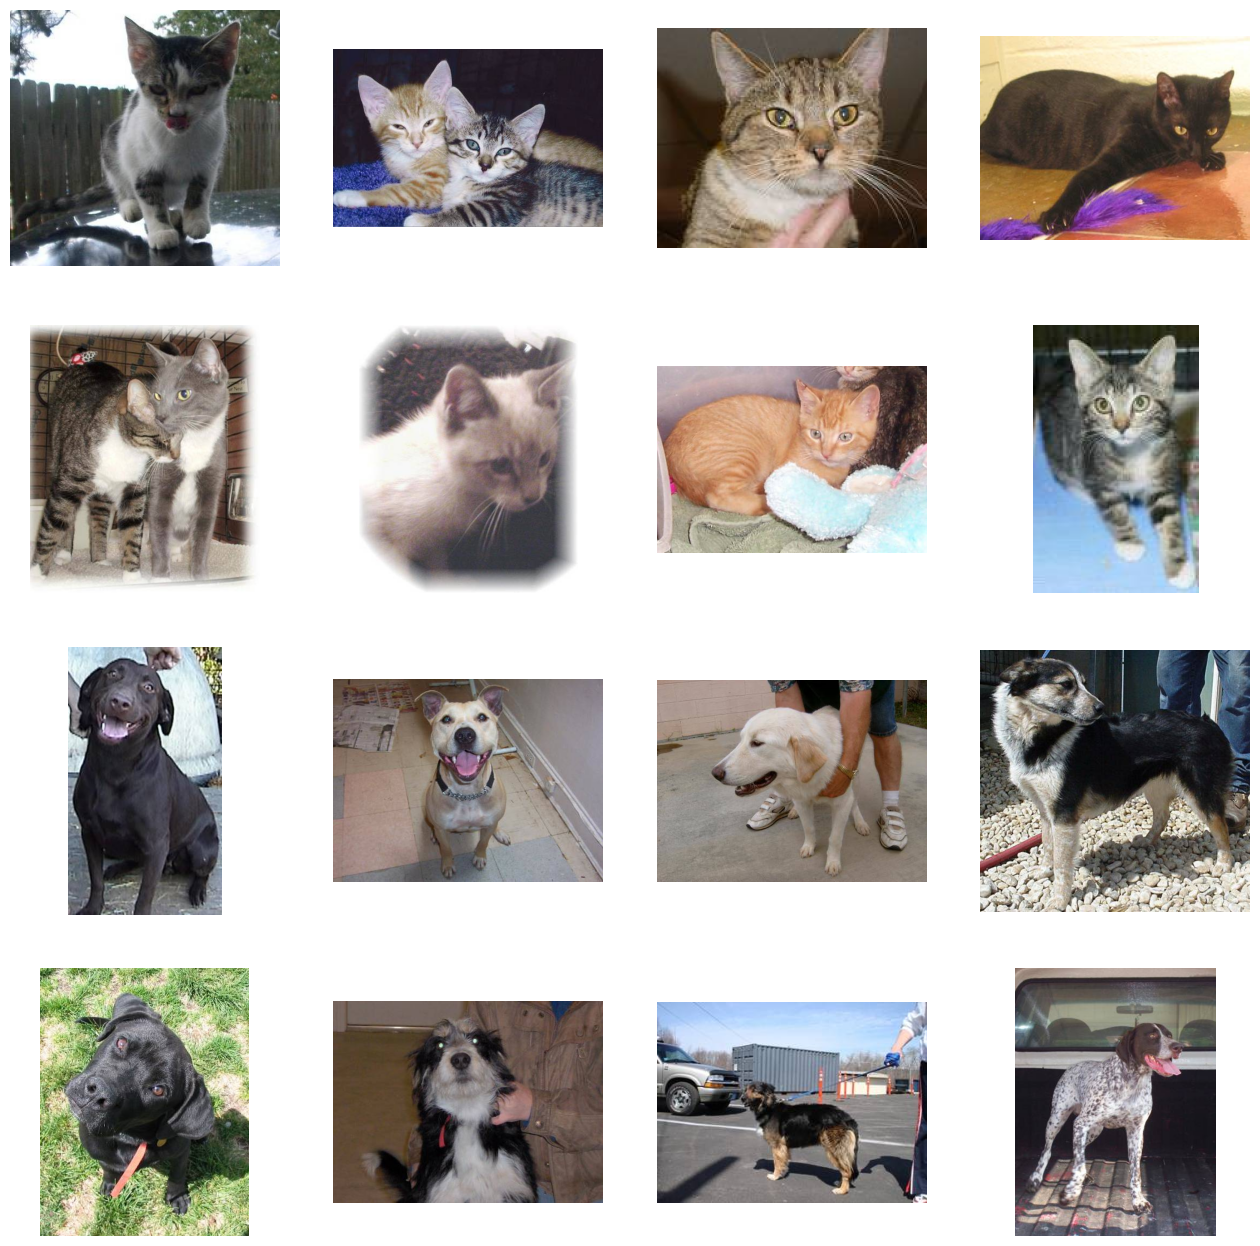

In [ ]:
# now we will look at a few images:
# this will show 8 random images for the train_cats_dir
# this will show 8 random images for the train_dogs_dir

# This is a magic command to request matplotlib for interactive support
# %matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# we will show images in a 4x4 tile configuration
nrows = 4
ncols = 4
# set a random value for this index between 0 and 999-8 (1000 train images)
pic_index = random.randint(0, 1000-8)

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Step 2 - Data Preloading

Set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and predict_generator.

In [ ]:
# Preparing data to be loaded into keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale color values for all images from [0-255] to [0.0-1.0]
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

# resize image to 150 x 150 pixles
# organize images in batches of 20 images
print ('Images assigned to the Train Generator:')
print ('   ', end = '')
train_generator = train_datagen.flow_from_directory(
        train_dir,            # This is the source directory for training images
        target_size = (150, 150),  #                           resize to 150x150
        batch_size  = 20,          #                               batches of 20
        class_mode  = 'binary')    # for binary_crossentropy loss, binary labels

print ('Images assigned to the Validation Generator:')
print ('   ', end = '')
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size =(150, 150),
        batch_size  = 20,
        class_mode  = 'binary')


Images assigned to the Train Generator:
   Found 2000 images belonging to 2 classes.
Images assigned to the Validation Generator:
   Found 1000 images belonging to 2 classes.


##Step 3 - VGG-16 network using keras


Step 3A - keras model - load the VGG16 model, compile it and summarize it.

Step 3B - keras model - train the model

Step 3C - keras model - plot the train and validation accuracy and loss functions


In [ ]:
# Step 3 - keras model  - load the VGG-16 model, compile it and summarize it.

# prompt for ChatGPT

# I am working in a colab notebook in python
# I am working on a machine learning project
# I am working with images
# I have 2 classes:  cats and dogs.
# The directory structure of the dataset is:
# base_dir            = '/content/cats_dogs'
# train_dir           = os.path.join(base_dir, 'train')
# validation_dir      = os.path.join(base_dir, 'validation')
# train_cats_dir      = os.path.join(train_dir, 'cats')
# train_dogs_dir      = os.path.join(train_dir, 'dogs')
# validation_cats_dir = os.path.join(validation_dir, 'cats')
# validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# Images are 150 x 150 pixels in 3 colors.
# I have already loaded them into keras, creating a train_generator and a validation_generator
# Load the VGG-16 model in keras, compile it and summarize it.


# So this code will load the VGG-16 network, with a set of weights pretrained
# for the "imagenet" dataset


In [ ]:
# Step 3 - keras model - load the VGG-16 model, compile it and summarize it.

import os
from keras.applications import VGG16
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# Define directories
base_dir = '/content/cats_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Define image dimensions
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)

# Load pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification (cats vs dogs)

# Compile the model
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescale validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=20,
    class_mode='binary'
)

# Let's summarize the model architecture:
print ()
print ('Model Summary')
print ()
model.summary()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.

Model Summary

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable pa

In [ ]:
# Step 3 - keras model - train the model

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=100, # usualy: number of training samples in dataset / batch size
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50 # usualy: number of validation samples in dataset / batch size
)

Epoch 1/20
100/100 [==============================] - 20s 186ms/step - loss: 0.5782 - accuracy: 0.6945 - val_loss: 0.4315 - val_accuracy: 0.7900
Epoch 2/20
100/100 [==============================] - 18s 184ms/step - loss: 0.4626 - accuracy: 0.7765 - val_loss: 0.3186 - val_accuracy: 0.8600
Epoch 3/20
100/100 [==============================] - 18s 182ms/step - loss: 0.4203 - accuracy: 0.7995 - val_loss: 0.3468 - val_accuracy: 0.8370
Epoch 4/20
100/100 [==============================] - 18s 184ms/step - loss: 0.3965 - accuracy: 0.8160 - val_loss: 0.2986 - val_accuracy: 0.8710
Epoch 5/20
100/100 [==============================] - 18s 182ms/step - loss: 0.3832 - accuracy: 0.8270 - val_loss: 0.2878 - val_accuracy: 0.8680
Epoch 6/20
100/100 [==============================] - 19s 187ms/step - loss: 0.3702 - accuracy: 0.8355 - val_loss: 0.2654 - val_accuracy: 0.8740
Epoch 7/20
100/100 [==============================] - 18s 181ms/step - loss: 0.3557 - accuracy: 0.8485 - val_loss: 0.2779 - val_ac

In [ ]:
# Optionally, you can save the trained model

#odel.save('/content/cats_dogs_vgg16_model.h5')
model.save('/content/cats_dogs_vgg16_model.keras')

In [ ]:
# Step 3 - keras model - plot the training/validation accuracy and loss.

# prompt for ChatGPT

# Now plot the training/validation accuracy and loss as collected during the training.

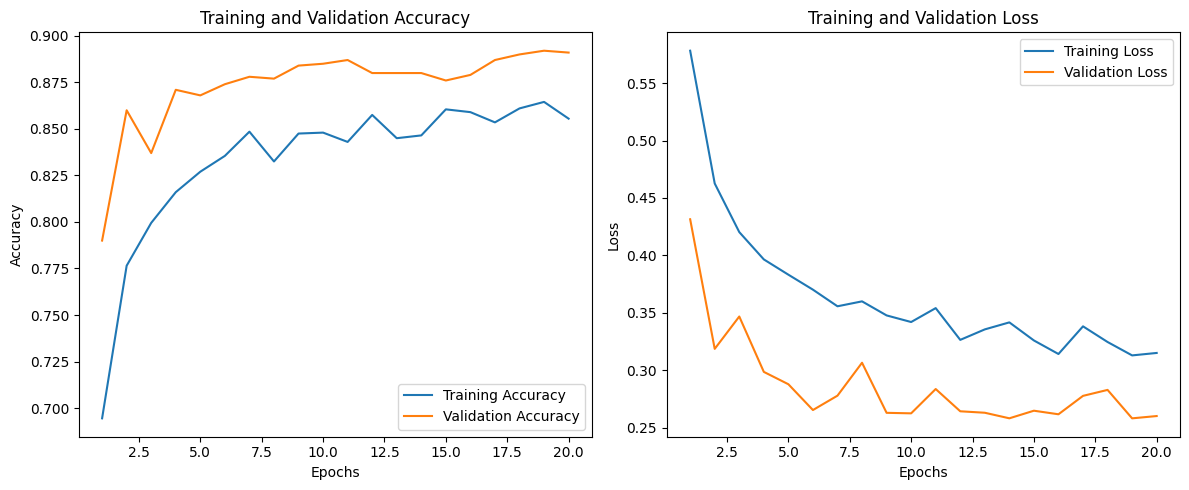

In [ ]:
# Step 3 - keras model - plot the training/validation accuracy and loss.

#import matplotlib.pyplot as plt

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# (experimental)
# Reset states to clear training history

import numpy as np

# Print the initial training history
print("Initial Training History:", model.history.history)

# Reset states to clear training history
# model.reset_states()

# to delete the weights
# Assuming 'model' is your existing model
new_weights = [np.random.randn(*w.shape) for w in model.get_weights()]
model.set_weights(new_weights)

# Print the initial training history
print("Current Training History:", model.history.history)


##Step 4 - VGG-16 network using pytorch

Step 4A - pytorch model - load the VGG16 model, compile it and summarize it.

Step 4B - pytorch model - train the model

Step 4C - pytorch model - plot the train and validation accuracy and loss functions

In [ ]:
# Step 4 - pytorch model

# prompt for ChatGPT

# I am working in a colab notebook in python
# I am working on a machine learning project
# I am working with images
# I have 2 classes:  cats and dogs.
# The directory structure of the dataset is:
# base_dir            = '/content/cats_dogs'
# train_dir           = os.path.join(base_dir, 'train')
# validation_dir      = os.path.join(base_dir, 'validation')
# train_cats_dir      = os.path.join(train_dir, 'cats')
# train_dogs_dir      = os.path.join(train_dir, 'dogs')
# validation_cats_dir = os.path.join(validation_dir, 'cats')
# validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# Images are 150 x 150 pixels in 3 colors.
# Using pytorch:
#   make a VGG-16 model,
#   train it,
# and plot the training / validation accuracy and loss.

In [ ]:
# Step 4 - pytorch model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

# Create datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(base_dir, x), data_transforms[x]) for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

# load the pretrained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the classifier to match your number of classes (2 for cats and dogs)
model.classifier[6] = nn.Linear(4096, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
# Step 4 - pytorch model - define a train model function

def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
# Step 4 - pytorch model - train the model.

def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10  # You can adjust the number of epochs
model = train_model(model, criterion, optimizer, num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 0.1423 Acc: 0.9410
validation Loss: 0.0771 Acc: 0.9680

Epoch 1/9
----------
train Loss: 0.1434 Acc: 0.9355
validation Loss: 0.0517 Acc: 0.9780

Epoch 2/9
----------
train Loss: 0.1415 Acc: 0.9360
validation Loss: 0.0375 Acc: 0.9820

Epoch 3/9
----------
train Loss: 0.1373 Acc: 0.9430
validation Loss: 0.0466 Acc: 0.9820

Epoch 4/9
----------
train Loss: 0.1399 Acc: 0.9335
validation Loss: 0.0811 Acc: 0.9620

Epoch 5/9
----------
train Loss: 0.1276 Acc: 0.9460
validation Loss: 0.0515 Acc: 0.9800

Epoch 6/9
----------
train Loss: 0.1293 Acc: 0.9455
validation Loss: 0.0496 Acc: 0.9840

Epoch 7/9
----------
train Loss: 0.1149 Acc: 0.9555
validation Loss: 0.0904 Acc: 0.9650

Epoch 8/9
----------
train Loss: 0.1244 Acc: 0.9445
validation Loss: 0.0417 Acc: 0.9830

Epoch 9/9
----------
train Loss: 0.1279 Acc: 0.9435
validation Loss: 0.0720 Acc: 0.9750

Training complete in 9m 44s
Best val Acc: 0.9840


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


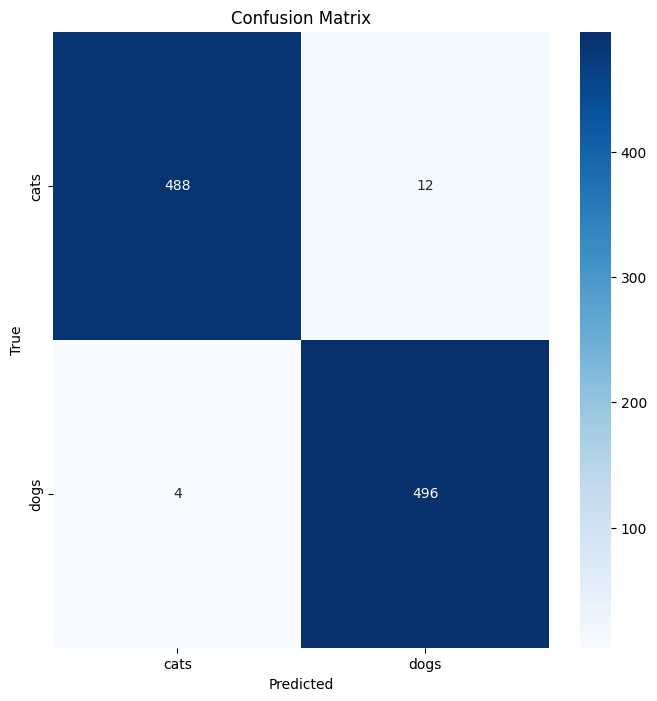

In [ ]:
# Step 4 - pytorch model - plot the confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to visualize the confusion matrix
def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader['validation']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(model, dataloaders)


In [ ]:
# Observations

# I observe here that in both cases (keras and pytorch)
# the validation accuracy is consistently higher than the training accuracy.
# also de train loss is consistently higher then the validation loss.

# This does not make much sense to me.
# I expect the model (any model) to show better accuracy with the train dataset,
# than with the validation dataset (data in which it has not been trained, unseen data, new data)

# I have checked the code that ChtGPT wrote for me, and found no errors.
#I could only attribute this to a dataset which is biased
# (like having easier images to classify in the validation set than in the
# training set)

#But I found no explanation yet.
